In [41]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [142]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
from astropy import units as u
from astropy.time import Time
from datetime import datetime
from astropy import visualization as aviz
from astropy.coordinates import SkyCoord
from astroquery.imcce import Skybot


This notebook runs on cuillin where the INT data is backed up.
We read all the nightly log files and compile them together into one large csv file/dataframe.
N.B. we could also access all the required information from the fits image headers directly, e.g. using ccdproc ImageFileCollection.

In [4]:
data_path = "/ceph/cephfs/SOLSYS" # path to INT data on cuillin
log_path = "{}/**/run_log_*.int".format(data_path)
logs = glob.glob(log_path, recursive=True)
logs.sort()
logs

['/ceph/cephfs/SOLSYS/INT_Aug_2022/20220818/run_log_20220818.int',
 '/ceph/cephfs/SOLSYS/INT_Aug_2022/20220819/run_log_20220819.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220302/run_log_20220302.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220303/run_log_20220303.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220304/run_log_20220304.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220305/run_log_20220305.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220306/run_log_20220306.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220307/run_log_20220307.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220308/run_log_20220308.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220309/run_log_20220309.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2022/20220310/run_log_20220310.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2023/data/20230313/run_log_20230313.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2023/data/20230314/run_log_20230314.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2023/data/20230315/run_log_20230315.int',
 '/ceph/cephfs/SOLSYS/INT_Mar_2023/data/2023031

In [5]:
def load_int_log(log_file):
    
    """
    Load an INT observing log file.
    Some columns may be a byte or two off.
    Labels for Slit, Grat and CenwA probably need some work.
    """
    labels = ["Run","Object","RA","Dec",
          "Equinox","UT","Airm","Instr","Texp sec","Sky PA","Filters etc.",
          "Slit","Grat","CenwA",
          "Comments"]
    
    byte_list = [(0,7),(7,25),(25,37),(37,48),
             (48,57),(57,63),(63,68),(68,75),(75,82),(82,87),(87,98),
            (98,106),(106,112),(112,118),
            (118,250)]
    
    df = pd.read_fwf(log_file, skiprows = 44, colspecs = byte_list, names = labels)
        
    # clean the comments etc from the dataframe
    df = df[pd.to_numeric(df['Run'], errors='coerce').notnull()].reset_index(drop=True)
    # make columns numeric where possible
    df = df.apply(pd.to_numeric, errors='ignore')
    
    # find the night as an integer
    print(log_file.split("run_log_")[-1].split(".")[0])
    df["night"] = [log_file.split("run_log_")[-1].split(".")[0]]*len(df)
    
    # fix midnight switch over
#     midnight_mask = df['mjd']%1<0.5
    midnight_mask = df["UT"].str.split(":").str[0].astype(int)<12
    df["date"] = df["night"].copy()
    df.loc[midnight_mask,"date"] = (df[midnight_mask]["date"].astype(int) + 1).astype(str) 
    # N.B. adding one to date might make an impossible date, e.g. 30 -> 31st Nov    
    
    # combine night and UT to get an mjd
    date_str = df["date"].astype(str) + " " + df["UT"]
    date_str = np.array(date_str).astype(str)
#     mjd = Time.strptime(date_str, '%Y%m%d %H:%M').mjd
#     df["mjd"] = mjd

    mjd_list = []
    for i,d in enumerate(date_str):
        
        try:
            mjd = Time.strptime(d, '%Y%m%d %H:%M').mjd
        except ValueError as e:  
            if str(e) != "day is out of range for month":
                raise
            else:
                print("deal with ValueError: {}".format(e))

                # month must be advanced by one, date reset to one
                month = d[4:6]
                date = d[6:8]
                _d = list(d)
                _d[4:6] = str(int(month)+1)
                _d[6:8] = "01"
                _d = "".join(_d)
                print("{}->{}".format(d,_d))
                
                mjd = Time.strptime(_d, '%Y%m%d %H:%M').mjd
        mjd_list.append(mjd)

    df["mjd"] = mjd_list
    
    # make columns numeric where possible
    df = df.apply(pd.to_numeric, errors='ignore')
    
    return df

In [6]:
df = load_int_log(logs[-1])

20221130
deal with ValueError: day is out of range for month
20221131 00:01->20221201 00:01
deal with ValueError: day is out of range for month
20221131 00:03->20221201 00:03
deal with ValueError: day is out of range for month
20221131 00:06->20221201 00:06
deal with ValueError: day is out of range for month
20221131 00:08->20221201 00:08
deal with ValueError: day is out of range for month
20221131 00:10->20221201 00:10
deal with ValueError: day is out of range for month
20221131 00:12->20221201 00:12
deal with ValueError: day is out of range for month
20221131 00:15->20221201 00:15
deal with ValueError: day is out of range for month
20221131 00:17->20221201 00:17
deal with ValueError: day is out of range for month
20221131 00:19->20221201 00:19
deal with ValueError: day is out of range for month
20221131 00:22->20221201 00:22
deal with ValueError: day is out of range for month
20221131 00:25->20221201 00:25
deal with ValueError: day is out of range for month
20221131 00:27->20221201 0

In [7]:
df.dtypes

Run               int64
Object           object
RA               object
Dec              object
Equinox         float64
UT               object
Airm            float64
Instr            object
Texp sec        float64
Sky PA            int64
Filters etc.     object
Slit            float64
Grat            float64
CenwA           float64
Comments         object
night             int64
date              int64
mjd             float64
dtype: object

In [8]:
df

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,Filters etc.,Slit,Grat,CenwA,Comments,night,date,mjd
0,1644473,Sky background,22:58:00.00,+00:04:59.9,2000.0,18:44,1.16,3 WFC,10.1,180,r,NaN,NaN,NaN,>40k counts,20221130,20221130,59913.780556
1,1644474,Sky background,22:58:00.00,+00:05:00.0,2000.0,18:45,1.16,2 WFC,10.1,180,r,NaN,NaN,NaN,pretty sure these are v close to the moon,20221130,20221130,59913.781250
2,1644475,Sky background,22:57:59.99,+00:05:10.0,2000.0,18:47,1.16,0 WFC,15.1,180,r,NaN,NaN,NaN,NaN,20221130,20221130,59913.782639
3,1644476,Sky background,22:58:00.66,+00:05:09.9,2000.0,18:49,1.15,8 WFC,25.1,180,r,NaN,NaN,NaN,NaN,20221130,20221130,59913.784028
4,1644477,Sky background,22:58:00.66,+00:04:59.9,2000.0,18:50,1.15,7 WFC,38.1,180,r,NaN,NaN,NaN,>50 k counts,20221130,20221130,59913.784722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,1644730,172P,7:28:32.00,+34:40:51.0,2000.0,06:38,1.20,5 WFC,100.0,180,r,NaN,NaN,NaN,NaN,20221130,20221131,59914.276389
258,1644731,172P,7:28:32.00,+34:40:50.9,2000.0,06:41,1.21,2 WFC,100.0,180,r,NaN,NaN,NaN,NaN,20221130,20221131,59914.278472
259,1644732,172P,7:28:32.00,+34:40:50.9,2000.0,06:43,1.22,0 WFC,100.1,180,r,NaN,NaN,NaN,bkg inc >1k,20221130,20221131,59914.279861
260,1644733,172P,7:28:32.00,+34:40:51.0,2000.0,06:46,1.22,7 WFC,100.0,180,r,NaN,NaN,NaN,NaN,20221130,20221131,59914.281944


In [9]:
def observing_run_log_int(log_file_list):
    
    """
    Load each night's log and combine into one dataframe
    """
    df_log = pd.DataFrame()
    for log in log_file_list:
        df_log = pd.concat((df_log,load_int_log(log)))

    df_log = df_log.reset_index(drop=True)
    return df_log

In [10]:
df_log = observing_run_log_int(logs)

20220818
20220819
20220302
20220303
20220304
20220305
20220306
20220307
20220308
20220309
20220310
20230313
20230314
20230315
20230316
20230317
20230318
20221119
20221120
20221121
20221128
20221129
20221130
deal with ValueError: day is out of range for month
20221131 00:01->20221201 00:01
deal with ValueError: day is out of range for month
20221131 00:03->20221201 00:03
deal with ValueError: day is out of range for month
20221131 00:06->20221201 00:06
deal with ValueError: day is out of range for month
20221131 00:08->20221201 00:08
deal with ValueError: day is out of range for month
20221131 00:10->20221201 00:10
deal with ValueError: day is out of range for month
20221131 00:12->20221201 00:12
deal with ValueError: day is out of range for month
20221131 00:15->20221201 00:15
deal with ValueError: day is out of range for month
20221131 00:17->20221201 00:17
deal with ValueError: day is out of range for month
20221131 00:19->20221201 00:19
deal with ValueError: day is out of range for 

In [11]:
df_log

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,Filters etc.,Slit,Grat,CenwA,Comments,night,date,mjd
0,1627409,Bias,0:00:00.00,+00:00:00.0,2000.0,11:02,1.08,2 IDS,0.0,0.0,GG395,1.0,R900V,6500.4,NaN,20220818,20220819,59810.459722
1,1627410,Arc,0:00:00.00,+00:00:00.0,2000.0,11:04,1.08,2 IDS,5.0,0.0,GG395,1.0,R900V,6500.4,NaN,20220818,20220819,59810.461111
2,1627411,Bias,0:00:00.00,+00:00:00.0,2000.0,11:06,1.00,0 IDS,0.0,0.0,GG395,1.0,R900V,6500.4,NaN,20220818,20220819,59810.462500
3,1627412,Arc,7:00:00.00,+49:59:59.8,2000.0,11:08,1.08,4 IDS,1.0,0.0,GG395,1.0,R900V,6500.4,NaN,20220818,20220819,59810.463889
4,1627413,Flat field,7:00:00.00,+49:59:59.9,2000.0,11:10,1.08,5 IDS,2.0,0.0,GG395,1.0,R900V,6500.4,NaN,20220818,20220819,59810.465278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,1644730,172P,7:28:32.00,+34:40:51.0,2000.0,06:38,1.20,5 WFC,100.0,180.0,r,NaN,NaN,NaN,NaN,20221130,20221131,59914.276389
5534,1644731,172P,7:28:32.00,+34:40:50.9,2000.0,06:41,1.21,2 WFC,100.0,180.0,r,NaN,NaN,NaN,NaN,20221130,20221131,59914.278472
5535,1644732,172P,7:28:32.00,+34:40:50.9,2000.0,06:43,1.22,0 WFC,100.1,180.0,r,NaN,NaN,NaN,bkg inc >1k,20221130,20221131,59914.279861
5536,1644733,172P,7:28:32.00,+34:40:51.0,2000.0,06:46,1.22,7 WFC,100.0,180.0,r,NaN,NaN,NaN,NaN,20221130,20221131,59914.281944


In [12]:
df_log.dtypes

Run               int64
Object           object
RA               object
Dec              object
Equinox         float64
UT               object
Airm            float64
Instr            object
Texp sec        float64
Sky PA          float64
Filters etc.     object
Slit            float64
Grat             object
CenwA           float64
Comments         object
night             int64
date              int64
mjd             float64
dtype: object

In [13]:
df_log["night"].value_counts()

20230318    424
20230313    347
20230315    326
20221121    319
20230316    316
20230317    308
20221128    278
20230314    271
20221130    262
20221120    246
20220302    234
20221129    228
20220306    226
20220309    221
20221119    214
20220307    204
20220308    202
20220310    180
20220818    173
20220303    157
20220304    143
20220305    141
20220819    118
Name: night, dtype: int64

In [14]:
df_log["Object"].value_counts()

169P         649
172P         499
Bias         426
388188       341
162P         289
            ... 
BD+174708      1
120            1
60             1
2              1
16+30          1
Name: Object, Length: 85, dtype: int64

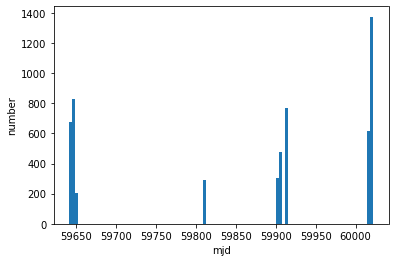

In [15]:
x_plot = "mjd"
# bins = "auto"
bins = 100
df_plot = df_log

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.hist(df_plot[x_plot], bins = bins)

ax1.set_xlabel(x_plot)
ax1.set_ylabel("number")

plt.show()

In [16]:
df_log["Filters etc."].value_counts()
# np.unique(df_log["Filters etc."])

r              2518
Sloan r 214    1761
g               303
Clear           284
i               136
Sloan g 220      85
Sloan i 215      70
Gunn z 195       65
U                57
[OII]3727        54
R                52
B                47
z                37
Halpha           22
V                19
Narrow-band      11
[OIII]5008       10
GG395             6
Name: Filters etc., dtype: int64

# Inspect the moving object targets in the log

In [17]:
# print all unique targets
v_counts = df_log["Object"].value_counts()
objects = v_counts.index.to_list()
# for x,n in zip(objects,v_counts.to_list()):
#     print(x,n)
print(objects)

['169P', '172P', 'Bias', '388188', '162P', 'Sky background', '7P', '143P', 'Flat field', 'DIDYMOS', '1998SV65', 'NAKANOTADAO', '2000RD101', '10P', 'FUCHIE', '1999WB22', '15P', '137P', '90403', '150P', '85275', '98943', '121P', '88992', 'C2017K2', '29P', '7891', '26P', '1998BU14', '189P', '1997WB22', 'Focus run', '73P', 'NAKANOTADO', 'NEREUS', '67P', 'BODE2', 'Arc', 'ROBINSON', '300P', 'Arc CuAr+CuNe', 'LOTR5', 'LTNF1', 'CABLANK3', 'C2020K1', '9P', '108P', 'hart l', 'hart r', '81P', '22P', 'SP0934+554', 'SP1337+705', 'SP1211+332', 'DR26', 'G191-B2B', 'Rotation-test', 'PNA666', 'C2020E3', 'BD+284211', 'CCD q-con Bias', 'CCD q-con Flat', 'WESB2', 'IPHASXJ0552262', 'IC2165', '15P2', 'KN63', 'IPHASXJ0552428', 'focus 15.5', 'C2021Y1', 'focus 15.45', 'focus 15.55', 'focus 15.6', 'focus 15.8', 'focus 15.65', 'focus 15.7', 'focus 15.75', 'focus 15.85', 'HD186427', '180', 'BD+174708', '120', '60', '2', '16+30']


In [18]:
# objects that are definitely not moving objects
objects_drop = ["Bias", "Sky background", "Flat field", "Focus run", "Arc", "Arc CuAr+CuNe",
               "SP0934+554", "SP1337+705", "SP1211+332", 'BD+284211', 'CCD q-con Bias',
 'CCD q-con Flat','focus 15.5', 'focus 15.45', 'focus 15.55', 'focus 15.6',
                'focus 15.8', 'focus 15.65', 'focus 15.7', 'focus 15.75', 'focus 15.85', 'HD186427', 'BD+174708']

In [19]:
# objects that are weird and might need checked
objects_inspect = ["BODE2","LOTR5","LTNF1","CABLANK3","hart l","hart r","DR26",
                  'G191-B2B',
 'Rotation-test',
 'PNA666','WESB2', 'IPHASXJ0552262', 'IC2165','KN63', 'IPHASXJ0552428',
                  '180', '120', '60', '2', '16+30']

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_log[np.isin(df_log["Object"],objects_inspect)])

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,Filters etc.,Slit,Grat,CenwA,Comments,night,date,mjd
6,1627415,Rotation-test,0:00:00.00,+00:00:00.0,2000.0,11:22,1.00,0 IDS,30.00,0.0,Clear,1.0,R400B,4505.5,NaN,20220818,20220819,59810.473611
7,1627416,Rotation-test,0:00:00.00,+00:00:00.0,2000.0,11:24,1.00,0 IDS,60.00,0.0,Clear,1.0,R400B,4505.5,NaN,20220818,20220819,59810.475000
8,1627417,Rotation-test,0:00:00.00,+00:00:00.0,2000.0,11:27,1.00,0 IDS,300.00,0.0,Clear,1.0,R400B,4505.5,NaN,20220818,20220819,59810.477083
9,1627418,Rotation-test,0:00:00.00,+00:00:00.0,2000.0,11:33,1.00,0 IDS,60.00,0.0,Clear,1.0,R400B,4414.5,NaN,20220818,20220819,59810.481250
10,1627419,Rotation-test,0:00:00.00,+00:00:00.0,2000.0,11:45,1.03,0 IDS,60.00,0.0,Clear,1.0,R400B,4414.5,NaN,20220818,20220819,59810.489583
11,1627420,hart l,0:00:00.00,+00:00:00.0,2000.0,11:47,1.03,0 IDS,120.00,0.0,Clear,1.0,R400B,4414.5,NaN,20220818,20220819,59810.490972
12,1627421,hart r,0:00:00.00,+00:00:00.0,2000.0,11:49,1.03,0 IDS,120.00,0.0,Clear,1.0,R400B,4414.5,NaN,20220818,20220819,59810.492361
13,1627422,hart l,0:00:00.00,+00:00:00.0,2000.0,11:53,1.03,0 IDS,300.00,0.0,Clear,1.0,R400B,4414.5,NaN,20220818,20220819,59810.495139
14,1627423,hart r,0:00:00.00,+00:00:00.0,2000.0,11:58,1.03,0 IDS,300.00,0.0,Clear,1.0,R400B,4414.5,NaN,20220818,20220819,59810.498611
15,1627424,hart l,0:00:00.00,+00:00:00.0,2000.0,12:06,1.03,0 IDS,120.00,0.0,Clear,1.0,R400B,4414.5,NaN,20220818,20220818,59809.504167


In [21]:
# keep only objects that are definite moving objects
objects_keep = np.array(objects)[~np.isin(objects,objects_drop+objects_inspect)]
print(objects_keep)

df_obj = df_log[np.isin(df_log["Object"],objects_keep)]

['169P' '172P' '388188' '162P' '7P' '143P' 'DIDYMOS' '1998SV65'
 'NAKANOTADAO' '2000RD101' '10P' 'FUCHIE' '1999WB22' '15P' '137P' '90403'
 '150P' '85275' '98943' '121P' '88992' 'C2017K2' '29P' '7891' '26P'
 '1998BU14' '189P' '1997WB22' '73P' 'NAKANOTADO' 'NEREUS' '67P' 'ROBINSON'
 '300P' 'C2020K1' '9P' '108P' '81P' '22P' 'C2020E3' '15P2' 'C2021Y1']


In [22]:
# fix some names, typos, renaming etc.
names_fix = {"NAKANOTADO":"NAKANOTADAO",
            "15P2":"15P",
            "1999WB22":"1997WB22"}
df_obj = df_obj.replace(names_fix)

In [23]:
df_obj["Object"].value_counts(),len(df_obj["Object"].value_counts())

(169P           649
 172P           499
 388188         341
 162P           289
 7P             234
 143P           225
 DIDYMOS        198
 NAKANOTADAO    186
 1998SV65       185
 1997WB22       159
 2000RD101      145
 FUCHIE         141
 10P            141
 15P            132
 137P           120
 90403          110
 150P            95
 85275           78
 98943           68
 121P            67
 88992           51
 C2017K2         43
 29P             42
 7891            41
 26P             29
 1998BU14        29
 189P            28
 73P             27
 NEREUS          20
 67P             18
 ROBINSON        11
 300P            10
 9P               7
 C2020K1          7
 81P              6
 22P              6
 108P             6
 C2020E3          4
 C2021Y1          3
 Name: Object, dtype: int64,
 39)

In [24]:
# weird nan entry?

df_obj[df_obj[["RA","Dec","mjd"]].isnull().any(axis=1)]

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,Filters etc.,Slit,Grat,CenwA,Comments,night,date,mjd
762,1602159,162P,NaN,NaN,NaN,04:41,NaN,WFC,60.1,NaN,r,NaN,NaN,NaN,RA and DEC not recorded in log?,20220304,20220305,59643.195139


In [25]:
# drop weird nan
df_obj = df_obj.dropna(subset = ["RA","Dec","mjd"]).reset_index(drop=True)

In [51]:
# ensure all observations are within date order
df_obj = df_obj.sort_values("mjd").reset_index(drop=True)

In [52]:
# get the positions of each frame
c = SkyCoord(df_obj["RA"],df_obj["Dec"], unit = (u.hourangle,u.degree))
c

<SkyCoord (ICRS): (ra, dec) in deg
    [(226.32579167, -22.00055556), (226.325625  , -22.00063889),
     (226.32541667, -22.00072222), ..., (204.79379167,  -4.17875   ),
     (204.79358333,  -4.17861111), (204.79345833,  -4.17847222)]>

In [53]:
c.ra.value,c.dec.value

(array([226.32579167, 226.325625  , 226.32541667, ..., 204.79379167,
        204.79358333, 204.79345833]),
 array([-22.00055556, -22.00063889, -22.00072222, ...,  -4.17875   ,
         -4.17861111,  -4.17847222]))

In [54]:
df_obj["RA_deg"] = c.ra.value
df_obj["Dec_deg"] = c.dec.value

# groupby for all objects

In [55]:
# min, median, max for mjd and ra/dec position (deg)

In [56]:
gb = df_obj.groupby("Object")

In [57]:
med_cols = {"RA_deg":"RA_deg_med","Dec_deg":"Dec_deg_med","mjd":"mjd_med"}
min_cols = {"RA_deg":"RA_deg_min","Dec_deg":"Dec_deg_min","mjd":"mjd_min"}
max_cols = {"RA_deg":"RA_deg_max","Dec_deg":"Dec_deg_max","mjd":"mjd_max"}

In [58]:
df_med = gb[["RA_deg","Dec_deg","mjd"]].median().reset_index().rename(med_cols,axis=1)
df_min = gb[["RA_deg","Dec_deg","mjd"]].min().reset_index().rename(min_cols,axis=1)
df_max = gb[["RA_deg","Dec_deg","mjd"]].max().reset_index().rename(max_cols,axis=1)
df_counts = gb.size().reset_index(name="N_frames")

In [59]:
df_objects = df_counts.merge(df_med, on ="Object").merge(df_min, on ="Object").merge(df_max, on ="Object")

In [60]:
df_objects["date_med"] = Time(df_objects["mjd_med"], format = "mjd").iso

In [61]:
df_objects

,Object,N_frames,RA_deg_med,Dec_deg_med,mjd_med,RA_deg_min,Dec_deg_min,mjd_min,RA_deg_max,Dec_deg_max,mjd_max,date_med
0,108P,6,104.157354,37.261222,59648.960764,104.144292,37.250361,59648.941667,104.163500,37.269917,59648.979861,2022-03-10 23:03:30.000
1,10P,141,104.983196,22.268917,60017.915972,104.982600,22.249139,60016.863889,104.987521,22.305417,60019.984722,2023-03-14 21:59:00.000
2,121P,67,79.983333,13.963028,59905.170139,79.983292,13.928000,59904.114583,80.141667,13.963056,59905.211806,2022-11-22 04:05:00.000
3,137P,120,172.813083,-2.253528,59649.091319,172.813000,-2.560444,59643.072917,173.521583,-2.253500,59649.206944,2022-03-11 02:11:30.000
4,143P,225,18.783333,11.425528,59911.943056,18.654125,11.349139,59902.880556,19.483333,11.805556,59913.904167,2022-11-28 22:38:00.000
5,150P,95,15.287458,28.504417,59904.920139,14.412417,27.397194,59902.888889,15.533333,28.751194,59913.975694,2022-11-21 22:05:00.000
6,15P,132,112.060125,30.104250,59646.049306,0.000000,0.000000,59641.943750,167.575000,30.346028,59914.224306,2022-03-08 01:11:00.000
7,162P,288,187.092333,22.420972,59644.256250,186.414667,22.276917,59642.222917,187.552792,22.614389,59647.152083,2022-03-06 06:09:00.000
8,169P,649,183.942708,0.011444,60021.141667,183.702792,-0.638889,60017.091667,185.112500,0.144833,60022.207639,2023-03-18 03:24:00.000
9,172P,499,112.224958,34.576389,59912.178472,63.258958,29.585917,59641.859028,112.954167,34.680917,59914.283333,2022-11-29 04:17:00.000


In [62]:
# weird values for NAKANOTADAO and 15P?

In [63]:
df_objects.to_csv("df_INT_objects.csv")

<IPython.core.display.Javascript object>


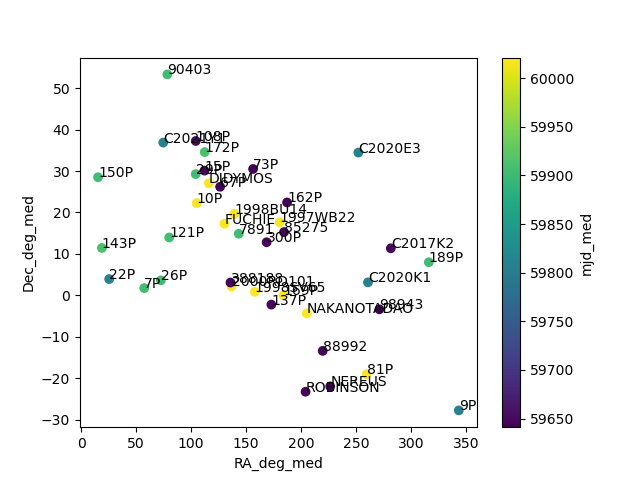

In [64]:
x_plot = "RA_deg_med"
y_plot = "Dec_deg_med"
c_plot = "mjd_med"

df_plot = df_objects

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

for i in range(len(df_plot)):
    x = df_plot.iloc[i]["Object"]
    ra = df_plot.iloc[i][x_plot]
    dec = df_plot.iloc[i][y_plot]
    mjd_min = df_plot.iloc[i]['mjd_min']
    mjd_max = df_plot.iloc[i]["mjd_max"]

#     ax1.text(ra,dec,"{}, {:.1f} -> {:.1f}".format(x,mjd_min,mjd_max))
#     ax1.text(ra,dec,"{}, {}".format(x,df_plot.iloc[i]["date_med"]))
    ax1.text(ra,dec,"{}".format(x))

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar = plt.colorbar(s1)

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar.set_label(c_plot)

plt.show()

In [65]:
# could also query each pointing with imcce skybot to look for other bright targets in FoV

<IPython.core.display.Javascript object>


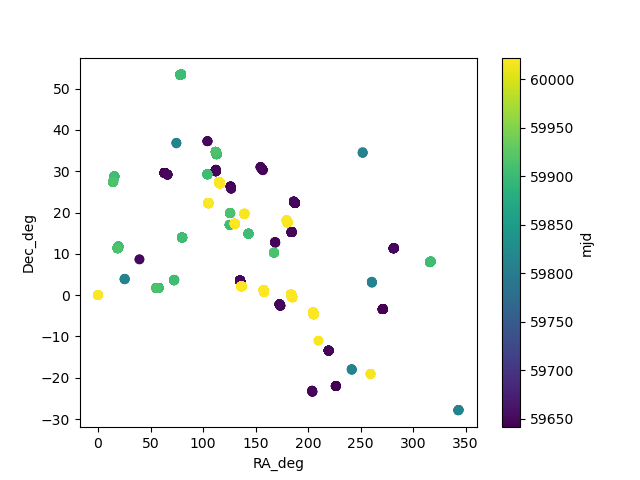

In [66]:
x_plot = "RA_deg"
y_plot = "Dec_deg"
c_plot = "mjd"

df_plot = df_obj

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

s1 = ax1.scatter(df_plot[x_plot],df_plot[y_plot], c = df_plot[c_plot])
cbar = plt.colorbar(s1)

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)
cbar.set_label(c_plot)

plt.show()

In [70]:
sep_cut = 17.0/60.0 # degrees

In [87]:
df_obj["search_group"] = np.nan

In [71]:
seps = c[1:].separation(c[:1]).value

In [73]:
seps

array([1.75567545e-04, 3.85574595e-04, 5.73922957e-04, ...,
       2.74417740e+01, 2.74420210e+01, 2.74422068e+01])

In [72]:
seps < sep_cut

array([ True,  True,  True, ..., False, False, False])

In [79]:
_sep = c[0].separation(c).value
sep_mask = _sep < sep_cut

In [84]:
df_obj[sep_mask]

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,Filters etc.,Slit,Grat,CenwA,Comments,night,date,mjd,RA_deg,Dec_deg
0,1601822,NEREUS,15:05:18.19,-22:00:02.0,2000.0,04:11,1.72,3 WFC,60.0,180.0,B,NaN,NaN,NaN,mirror closed,20220302,20220303,59641.174306,226.325792,-22.000556
1,1601823,NEREUS,15:05:18.15,-22:00:02.3,2000.0,04:14,1.71,3 WFC,59.6,180.0,B,NaN,NaN,NaN,NaN,20220302,20220303,59641.176389,226.325625,-22.000639
2,1601824,NEREUS,15:05:18.10,-22:00:02.6,2000.0,04:16,1.70,4 WFC,60.1,180.0,R,NaN,NaN,NaN,NaN,20220302,20220303,59641.177778,226.325417,-22.000722
3,1601825,NEREUS,15:05:18.06,-22:00:03.0,2000.0,04:19,1.69,6 WFC,59.5,180.0,R,NaN,NaN,NaN,looking for asteriod,20220302,20220303,59641.179861,226.325250,-22.000833
4,1601826,NEREUS,15:05:18.02,-22:00:03.3,2000.0,04:22,1.68,7 WFC,60.1,180.0,V,NaN,NaN,NaN,NaN,20220302,20220303,59641.181944,226.325083,-22.000917
5,1601827,NEREUS,15:05:17.99,-22:00:03.4,2000.0,04:23,1.68,3 WFC,60.1,180.0,R,NaN,NaN,NaN,NaN,20220302,20220303,59641.182639,226.324958,-22.000944
6,1601828,NEREUS,15:05:17.97,-22:00:03.6,2000.0,04:24,1.67,8 WFC,60.0,180.0,z,NaN,NaN,NaN,NaN,20220302,20220303,59641.183333,226.324875,-22.001000
7,1601829,NEREUS,15:05:17.93,-22:00:03.9,2000.0,04:27,1.67,2 WFC,60.1,180.0,R,NaN,NaN,NaN,NaN,20220302,20220303,59641.185417,226.324708,-22.001083
8,1601830,NEREUS,15:05:17.91,-22:00:04.1,2000.0,04:28,1.66,7 WFC,60.0,180.0,B,NaN,NaN,NaN,NaN,20220302,20220303,59641.186111,226.324625,-22.001139
9,1601831,NEREUS,15:05:17.89,-22:00:04.2,2000.0,04:30,1.66,3 WFC,60.0,180.0,R,NaN,NaN,NaN,NaN,20220302,20220303,59641.187500,226.324542,-22.001167


In [85]:
i = df_obj[sep_mask].index[-1] + 1
_sep = c[i].separation(c).value
sep_mask = _sep < sep_cut

In [86]:
df_obj[sep_mask]

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,Filters etc.,Slit,Grat,CenwA,Comments,night,date,mjd,RA_deg,Dec_deg
20,1601842,98943,18:03:53.80,-03:22:40.9,2000.0,04:46,2.18,4 WFC,60.1,180.0,B,NaN,NaN,NaN,NaN,20220302,20220303,59641.198611,270.974167,-3.378028
21,1601843,98943,18:03:53.80,-03:22:41.0,2000.0,04:48,2.16,5 WFC,59.6,180.0,B,NaN,NaN,NaN,finding,20220302,20220303,59641.200000,270.974167,-3.378056
22,1601844,98943,18:03:53.87,-03:22:41.1,2000.0,04:51,2.11,6 WFC,60.1,180.0,B,NaN,NaN,NaN,NaN,20220302,20220303,59641.202083,270.974458,-3.378083
23,1601845,98943,18:03:54.09,-03:22:41.6,2000.0,04:52,2.09,6 WFC,59.6,180.0,R,NaN,NaN,NaN,NaN,20220302,20220303,59641.202778,270.975375,-3.378222
24,1601846,98943,18:03:54.30,-03:22:42.1,2000.0,04:54,2.07,8 WFC,60.1,180.0,V,NaN,NaN,NaN,NaN,20220302,20220303,59641.204167,270.976250,-3.378361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1601905,98943,18:04:09.03,-03:23:16.5,2000.0,06:29,1.37,9 WFC,60.1,180.0,R,NaN,NaN,NaN,NaN,20220302,20220303,59641.270139,271.037625,-3.387917
84,1601906,98943,18:04:09.24,-03:23:17.0,2000.0,06:31,1.37,4 WFC,60.0,180.0,V,NaN,NaN,NaN,NaN,20220302,20220303,59641.271528,271.038500,-3.388056
85,1601907,98943,18:04:09.45,-03:23:17.4,2000.0,06:32,1.36,9 WFC,60.1,180.0,R,NaN,NaN,NaN,NaN,20220302,20220303,59641.272222,271.039375,-3.388167
86,1601908,98943,18:04:09.66,-03:23:18.1,2000.0,06:33,1.36,4 WFC,60.0,180.0,z,NaN,NaN,NaN,NaN,20220302,20220303,59641.272917,271.040250,-3.388361


In [135]:
i = 0
group = 0

while i < len(df_obj):

    print(i)
    
    # find all separations within the desired search radius
    # we assume df_obj is in mjd order
    _sep = c[i].separation(c).value
    sep_mask = _sep < sep_cut
    
    # ignore previous frames
    sep_mask[:i] = False
    
#     print(df_obj[sep_mask].index)

    # select only the first group of Trues
    # https://stackoverflow.com/questions/66476980/find-groups-of-neighboring-true-in-pandas-series
    # no idea how this works...
    s = pd.Series(sep_mask)
    for _,x in s[s].groupby((1-s).cumsum()):
        print(f'from {x.index[0]} to {x.index[-1]}')
        i = x.index[-1] + 1
        break
        
    sep_mask[i:] = False
        
    print(df_obj[sep_mask].index)

    # assign a cluster id
    df_obj.loc[sep_mask,"search_group"] = group
    group += 1
    
#     # find the first observation that is not in the cluster for the next search
#     i = df_obj[sep_mask].index[-1] + 1
    
    print(i,sum(sep_mask),i+sum(sep_mask))
    
#     if i>120:
#         break


0
from 0 to 19
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')
20 20 40
20
from 20 to 87
Int64Index([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
            37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
            54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
            71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
            87],
           dtype='int64')
88 68 156
88
from 88 to 115
Int64Index([ 88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
            101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
            114, 115],
           dtype='int64')
116 28 144
116
from 116 to 119
Int64Index([116, 117, 118, 119], dtype='int64')
120 4 124
120
from 120 to 120
Int64Index([120], dtype='int64')
121 1 122
121
from 121 to 123
Int64Index([121, 122, 123], dtype='int64')
124 3 127
124
from 124 to 159
Int

from 966 to 977
Int64Index([966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977], dtype='int64')
978 12 990
978
from 978 to 982
Int64Index([978, 979, 980, 981, 982], dtype='int64')
983 5 988
983
from 983 to 997
Int64Index([983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995,
            996, 997],
           dtype='int64')
998 15 1013
998
from 998 to 1002
Int64Index([998, 999, 1000, 1001, 1002], dtype='int64')
1003 5 1008
1003
from 1003 to 1017
Int64Index([1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
            1014, 1015, 1016, 1017],
           dtype='int64')
1018 15 1033
1018
from 1018 to 1022
Int64Index([1018, 1019, 1020, 1021, 1022], dtype='int64')
1023 5 1028
1023
from 1023 to 1037
Int64Index([1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033,
            1034, 1035, 1036, 1037],
           dtype='int64')
1038 15 1053
1038
from 1038 to 1042
Int64Index([1038, 1039, 1040, 1041, 1042], dtype='int64')
1043 5 1048
1043
from 1043 

from 1982 to 2012
Int64Index([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
            1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
            2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
           dtype='int64')
2013 31 2044
2013
from 2013 to 2086
Int64Index([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
            2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034,
            2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045,
            2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056,
            2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067,
            2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078,
            2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086],
           dtype='int64')
2087 74 2161
2087
from 2087 to 2101
Int64Index([2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097,
            2098, 2099, 2100

In [140]:
df_obj[pd.isnull(df_obj["search_group"])]

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,...,Slit,Grat,CenwA,Comments,night,date,mjd,RA_deg,Dec_deg,search_group


<IPython.core.display.Javascript object>


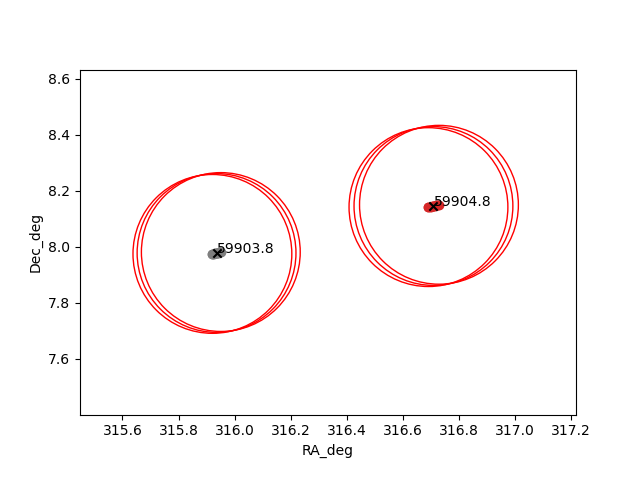

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.]


In [138]:
x_plot = "RA_deg"
y_plot = "Dec_deg"
c_plot = "mjd"

df_plot = df_obj

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

print(np.unique(df_plot["search_group"]))
for i in np.unique(df_plot["search_group"]):

#     print(i)
    
    _df_plot = df_plot[df_plot['search_group']==i]
    s1 = ax1.scatter(_df_plot[x_plot],_df_plot[y_plot])
    
    ra_med = np.median(_df_plot[x_plot])
    dec_med = np.median(_df_plot[y_plot])
    mjd_med = np.median(_df_plot[c_plot])
    
    ax1.scatter(ra_med,dec_med,marker = "x", c = "k")
    ax1.text(ra_med,dec_med,"{:.1f}".format(mjd_med))
    circle1 = plt.Circle((ra_med,dec_med), sep_cut, edgecolor='r', facecolor = "none")
    ax1.add_patch(circle1)
  
    # consider start and end points of each cluster
#     for j in [0,-1]:
#         circle1 = plt.Circle((np.array(_df_plot[x_plot])[j],np.array(_df_plot[y_plot])[j]), sep_cut, edgecolor='r', facecolor = "none")
#         ax1.add_patch(circle1)

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

ax1.set_aspect("equal")

plt.show()

In [144]:
df_obj

,Run,Object,RA,Dec,Equinox,UT,Airm,Instr,Texp sec,Sky PA,...,Slit,Grat,CenwA,Comments,night,date,mjd,RA_deg,Dec_deg,search_group
0,1601822,NEREUS,15:05:18.19,-22:00:02.0,2000.0,04:11,1.72,3 WFC,60.00,180.0,...,NaN,NaN,NaN,mirror closed,20220302,20220303,59641.174306,226.325792,-22.000556,0.0
1,1601823,NEREUS,15:05:18.15,-22:00:02.3,2000.0,04:14,1.71,3 WFC,59.60,180.0,...,NaN,NaN,NaN,NaN,20220302,20220303,59641.176389,226.325625,-22.000639,0.0
2,1601824,NEREUS,15:05:18.10,-22:00:02.6,2000.0,04:16,1.70,4 WFC,60.10,180.0,...,NaN,NaN,NaN,NaN,20220302,20220303,59641.177778,226.325417,-22.000722,0.0
3,1601825,NEREUS,15:05:18.06,-22:00:03.0,2000.0,04:19,1.69,6 WFC,59.50,180.0,...,NaN,NaN,NaN,looking for asteriod,20220302,20220303,59641.179861,226.325250,-22.000833,0.0
4,1601826,NEREUS,15:05:18.02,-22:00:03.3,2000.0,04:22,1.68,7 WFC,60.10,180.0,...,NaN,NaN,NaN,NaN,20220302,20220303,59641.181944,226.325083,-22.000917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4444,1661478,NAKANOTADAO,13:39:10.60,-04:10:44.6,2000.0,06:08,1.74,WFC,60.02,180.0,...,NaN,NaN,NaN,None,20230318,20230319,60022.255556,204.794167,-4.179056,150.0
4445,1661479,NAKANOTADAO,13:39:10.55,-04:10:44.2,2000.0,06:09,1.75,WFC,60.02,180.0,...,NaN,NaN,NaN,None,20230318,20230319,60022.256250,204.793958,-4.178944,150.0
4446,1661480,NAKANOTADAO,13:39:10.51,-04:10:43.5,2000.0,06:11,1.77,WFC,60.05,180.0,...,NaN,NaN,NaN,None,20230318,20230319,60022.257639,204.793792,-4.178750,150.0
4447,1661481,NAKANOTADAO,13:39:10.46,-04:10:43.0,2000.0,06:13,1.78,WFC,60.15,180.0,...,NaN,NaN,NaN,None,20230318,20230319,60022.259028,204.793583,-4.178611,150.0


In [145]:
df_obj.to_csv("df_INT_obs.csv")